In [3]:
import os
import math
from shutil import copyfile

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode
from utils.loader import environments, WeatherTransform

from utils.common import setup_seed 
from tqdm import tqdm

# 生成器
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # 定义U-Net或其他适合图像修复的网络结构
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 判别器
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
            #nn.Sigmoid()
        )
        self.fc = nn.Sequential(
            nn.Linear(15*15,1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


    
class MyDataset(datasets.ImageFolder):
    def __init__(self, root, transform = None, target_transform = None, style='normal', h=256, w=256):
        super().__init__(root, transform = transform, target_transform = target_transform)
        self.h = h 
        self.w = w 
        self.weather = style

    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        t_normal = transforms.Compose(
                [
                    transforms.Resize((self.h, self.w), interpolation=InterpolationMode.BICUBIC),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ]
            )
        
        t_aug = transforms.Compose(
                [
                    transforms.Resize((self.h, self.w), interpolation=InterpolationMode.BICUBIC),
                    WeatherTransform(aug=self.weather),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ]
            )
        t = transforms.Compose(
                [
                    transforms.Resize((self.h, self.w), interpolation=InterpolationMode.BICUBIC),
                    WeatherTransform(aug=self.weather),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ]
            )
        
        img_normal = t_normal(img)
        img_aug = t_aug(img)
        return img_aug, img_normal 

    def __len__(self):
        return len(self.imgs)
    

from matplotlib import pyplot as plt

def imshow(img):
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = img.numpy()
    plt.imshow((np.transpose(img, (1,2,0)) * 255).astype('uint8'))
    plt.axis('off')
    plt.show() 
    
def test(style='fog', batchsize=8, epoch=1, filter_name=None):
    if filter_name==None:
        filter_name=style

    #device = torch.device('cuda')
    generator = Generator()#.to(device)
    discriminator = Discriminator()#.to(device)

    data_set = MyDataset(os.path.join(os.getcwd(), 'University-Release', 'test', 'query_drone'), style=style)
    data_loader = torch.utils.data.DataLoader(data_set, batch_size=batchsize, shuffle=True, num_workers=0, pin_memory=False)
    save_path = os.path.join(os.getcwd(), 'model', 'GAN', 'generator_{}_{:03d}.pth'.format(filter_name, epoch))
    generator.load_state_dict(torch.load(save_path)) 
    save_path = os.path.join(os.getcwd(), 'model', 'GAN', 'discriminator_{}_{:03d}.pth'.format(filter_name, epoch))
    discriminator.load_state_dict(torch.load(save_path)) 

    dataiter = iter(data_loader)
    img_aug, img = dataiter.next()
    
    with torch.no_grad():
        outputs = generator(img_aug)

    n = np.random.choice(list(range(batchsize)))

    imshow(img_aug[n])
    imshow(outputs[n])
    imshow(img[n])
    
def train(model_dir = None, style='fog', batchsize=8, lr_g=0.0002,lr_d=0.0002, num_epoch=60):
    if model_dir == None:
        model_dir = os.path.join(os.getcwd(), 'model', 'GAN')
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    device = torch.device('cuda')
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)

    data_set = MyDataset(os.path.join(os.getcwd(), 'University-Release', 'train', 'drone'), style=style)
    data_loader = torch.utils.data.DataLoader(data_set, batch_size=batchsize, shuffle=True, num_workers=0, pin_memory=False)

    optimizer_g = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
    
    criterion = nn.BCELoss()
    l1_loss = nn.L1Loss()
    
    for epoch in range(1, num_epoch+1):
        epoch_loss = 0
        for i, (img_aug, img) in enumerate(data_loader):
            img_aug, img_normal = img_aug.cuda(), img.cuda() 
            
            # 训练判别器
            optimizer_d.zero_grad()
            
            # 使用真实图像训练判别器
            real_labels = torch.ones(img_normal.size(0), 1)
            real_labels = real_labels.cuda()
            outputs = discriminator(img_normal)
            #print(outputs.shape, real_labels.shape)
            d_loss_real = criterion(outputs, real_labels)
            
            # 使用生成图像训练判别器
            fake_images = generator(img_aug)
            fake_labels = torch.zeros(img_aug.size(0), 1)
            fake_labels = fake_labels.cuda()
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(outputs, fake_labels)
            
            # 总的判别器损失
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_d.step()
            
            # 训练生成器
            optimizer_g.zero_grad()
            
            # 生成器损失
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels) + l1_loss(fake_images, img_normal)
            g_loss.backward()
            optimizer_g.step()
        
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch}/{num_epoch}], Step [{i+1}/{len(data_loader)}], '
                    f'D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

        save_filename = 'generator_{}_{:03d}.pth'.format(style, epoch)
        save_path = os.path.join(model_dir, save_filename)
        torch.save(generator.cpu().state_dict(), save_path)
        generator.cuda()  

        save_filename = 'discriminator_{}_{:03d}.pth'.format(style, epoch)
        save_path = os.path.join(model_dir, save_filename)
        torch.save(discriminator.cpu().state_dict(), save_path)
        discriminator.cuda()  

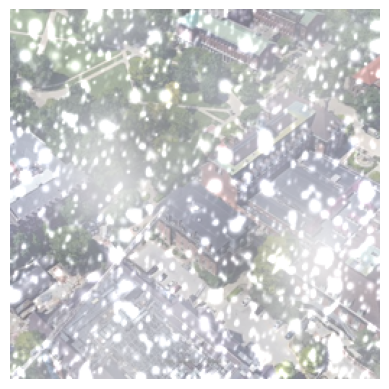

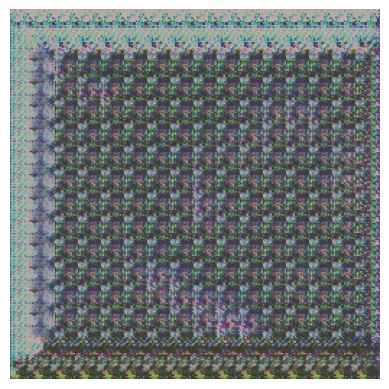

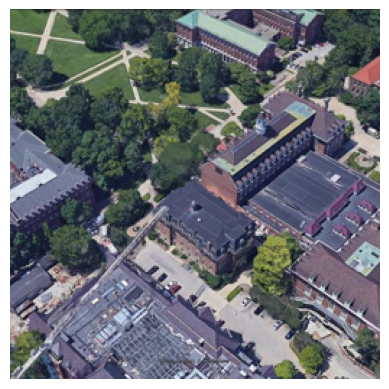

In [10]:
test(style='fog_snow',epoch=2)